In [1]:
import matplotlib
import seaborn
import pandas
import gzip
import igraph
import itertools
import re
import os

#import statsmodels
#import scipy.stats

from collections import Counter, OrderedDict

%matplotlib inline

seaborn.set_style('whitegrid')
seaborn.set_palette('colorblind')

In [2]:
ecosystems = ['npm', 'cran', 'rubygems']

COLORS = {ecos: seaborn.color_palette()[i] for i, ecos in enumerate(ecosystems)}
FIG_SIZE = (6, 3)
FIG_SIZE_WIDE = (10, 3)
SHOW_TITLE = True

def savefig(fig, name):
    # Uncomment next line to disable export
    #return
    return fig.savefig('figures/{}.pdf'.format(name), bbox_inches='tight')

## Read graphs

In [3]:
GRAPH_DIR = '/data/graphs'

def read_graph(filename):
    g = igraph.read(os.path.join(GRAPH_DIR, filename), format='graphmlz')
    date = re.search(r'(\d\d\d\d-\d\d-\d\d)', filename).group(1)
    return date, g
    
def read_graphs(e):
    return [read_graph(f) for f in os.listdir(GRAPH_DIR)
            if re.search(r'^{}.*\.graphml\.gz'.format(e), f)]

graphs = OrderedDict((e, dict(read_graphs(e))) for e in ecosystems)

## Compute metrics

In [4]:
def graph_metrics(g, d, e):
    return {'time': d, 'ecos': e, 'size': len(g.vs),
            'biggest_wcc': len(g.components(igraph.WEAK).giant().vs) if len(g.vs) else 0,
            'with_deps': len([x for x in g.outdegree() if x > 0]),
            'with_revdeps': len([x for x in g.indegree() if x > 0]),
            'isolated': len([x for x in g.degree() if x == 0])}

def ecos_metrics(e, x):
    metrics = pandas.DataFrame([graph_metrics(g, d, e) for d, g in x.items()])
    metrics['time'] = pandas.to_datetime(metrics.time)
    return metrics.set_index(['time']).sort_index()

ecos_metrics = OrderedDict((e, ecos_metrics(e, x)) for e, x in graphs.items())

In [5]:
dates = pandas.date_range('2012-01-01', '2016-01-01', freq='AS')

def package_metrics(e, g):
    data = [pandas.DataFrame({'date': d, 'ecos': e, 'package': g.vs['name'], 'size': g.vs['size'],
                              'indegree': g.indegree(), 'outdegree': g.outdegree()})
            for d, g in g.items() if d in dates]
    return (pandas.concat(data)
            .assign(isolated=lambda d: d.indegree + d.outdegree == 0)
            .sort_values('date'))

package_metrics = {e: package_metrics(e, g) for e, g in graphs.items()}

## Preferential attachment

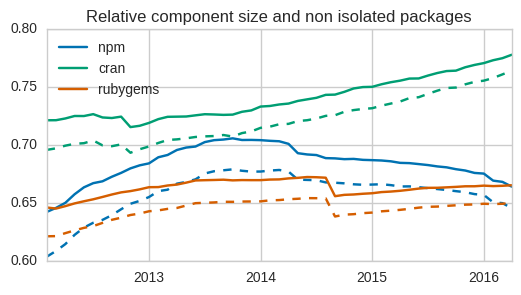

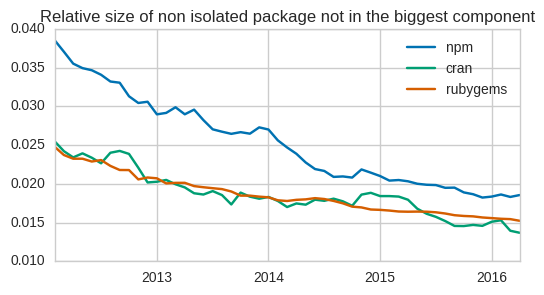

In [6]:
fig, ax = matplotlib.pyplot.subplots()
if SHOW_TITLE:
    ax.set_title('Relative component size and non isolated packages')
for e, m in ecos_metrics.items():
    data = (m.query('size > 1 and time > "2012"')
             .assign(biggest_wcc=lambda d: d.biggest_wcc / d['size'])
             .assign(isolated=lambda d: 1 - d.isolated / d['size']))
    data.biggest_wcc.plot(ax=ax, style='--', color=COLORS[e])
    data.isolated.plot(ax=ax, style='-', color=COLORS[e], label=e, legend=True)

ax.set_xlabel('')
ax.set_ylim(0.6,0.8)
fig.set_size_inches(FIG_SIZE)
savefig(fig, 'evol_component')

fig, ax = matplotlib.pyplot.subplots()
fig.set_size_inches(FIG_SIZE)
if SHOW_TITLE:
    ax.set_title('Relative size of non isolated package not in the biggest component')
for e, m in ecos_metrics.items():
    data = (m.query('size > 1 and time > "2012"')
             .assign(isolated=lambda d: (d['size'] - d.isolated - d.biggest_wcc) / d['size']))
    data.isolated.plot(ax=ax, style='-', color=COLORS[e], label=e, legend=True)

ax.set_xlabel('')
fig.set_size_inches(FIG_SIZE)
savefig(fig, 'evol_non_isolated_diff')

## Package size, indegree & outdegree

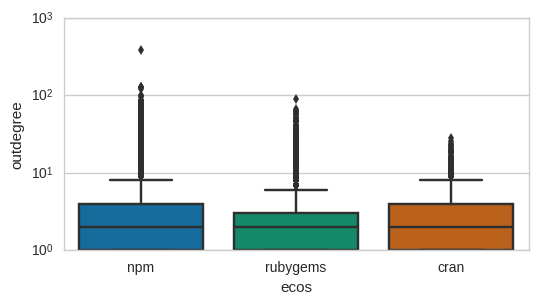

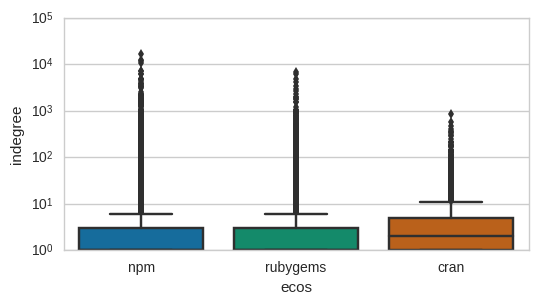

In [7]:
data = pandas.concat([data[data.date == max(data.date)] for data in package_metrics.values()], ignore_index=True)

fig, ax = matplotlib.pyplot.subplots()
seaborn.boxplot(data=data[data.outdegree > 0], x='ecos', y='outdegree', ax=ax)
ax.set_yscale('log')
fig.set_size_inches(FIG_SIZE)
savefig(fig, 'boxplot_outdegree')

fig, ax = matplotlib.pyplot.subplots()
seaborn.boxplot(data=data[data.indegree > 0], x='ecos', y='indegree', ax=ax)
ax.set_yscale('log')
fig.set_size_inches(FIG_SIZE)
savefig(fig, 'boxplot_indegree')

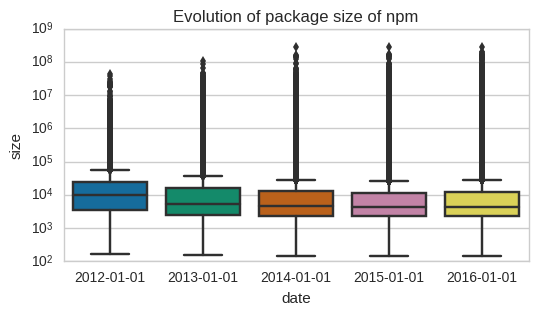

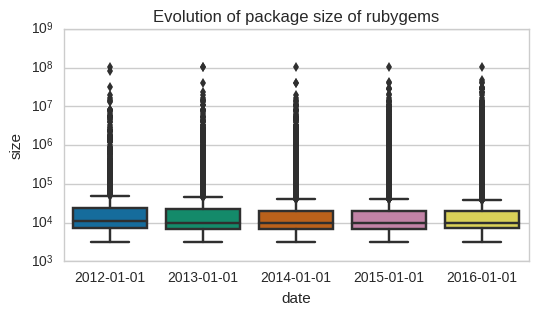

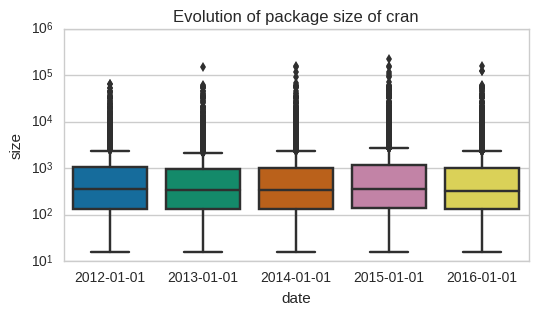

In [8]:
for e, data in package_metrics.items():
    fig, ax = matplotlib.pyplot.subplots()
    seaborn.boxplot(data=data, x='date', y='size', ax=ax)
    if SHOW_TITLE:
        ax.set_title('Evolution of package size of {}'.format(e))
    ax.set_yscale('log')
    fig.set_size_inches(FIG_SIZE)
    savefig(fig, 'boxplot_evol_size_{}'.format(e))

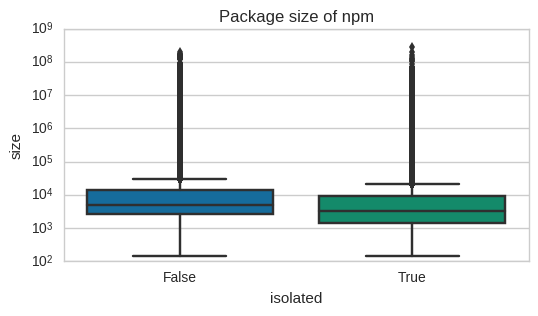

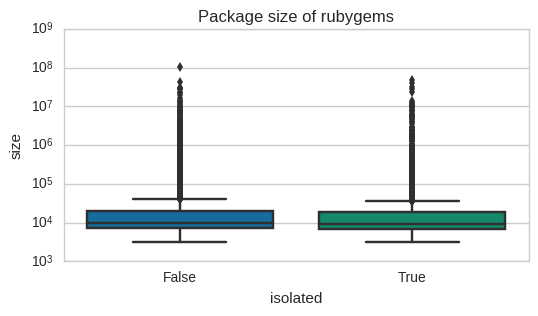

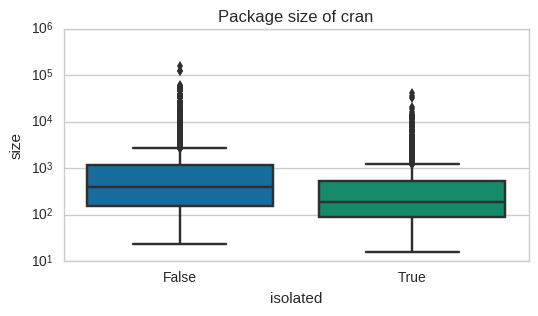

In [9]:
for e, data in package_metrics.items():
    fig, ax = matplotlib.pyplot.subplots()
    seaborn.boxplot(data=data[data.date == '2016-01-01'], x='isolated', y='size', ax=ax)
    if SHOW_TITLE:
        ax.set_title('Package size of {}'.format(e))
    ax.set_yscale('log')
    fig.set_size_inches(FIG_SIZE)
    savefig(fig, 'boxplot_size_isolated_{}'.format(e))

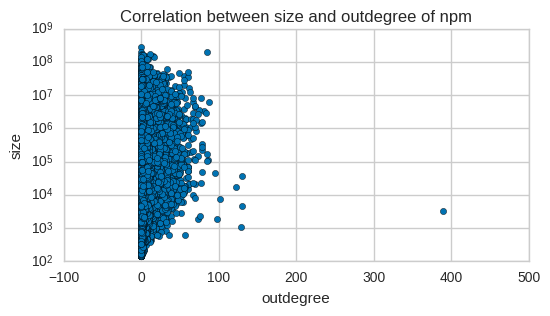

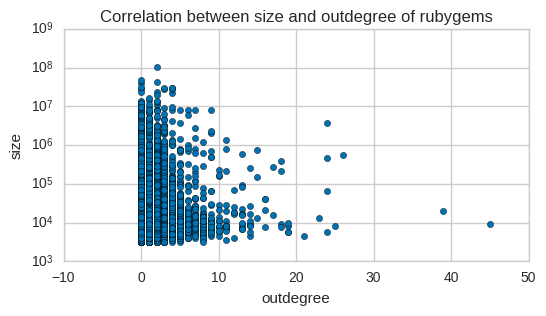

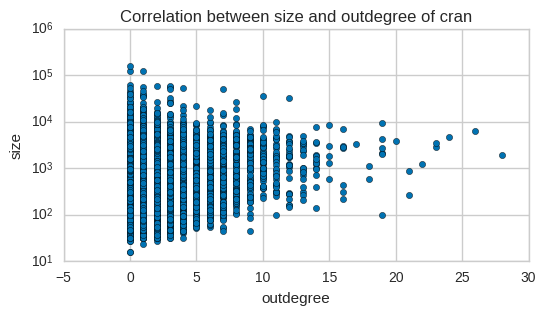

In [10]:
for e, data in package_metrics.items():
    fig, ax = matplotlib.pyplot.subplots()
    data[data.date == '2016-01-01'].plot.scatter(x='outdegree', y='size', ax=ax)
    #seaborn.jointplot(data=data[data.date == '2016-01-01'], x='outdegree', y='size', ax=ax)
    if SHOW_TITLE:
        ax.set_title('Correlation between size and outdegree of {}'.format(e))
    ax.set_yscale('log')
    fig.set_size_inches(FIG_SIZE)
    savefig(fig, 'scatter_size_out_{}'.format(e))

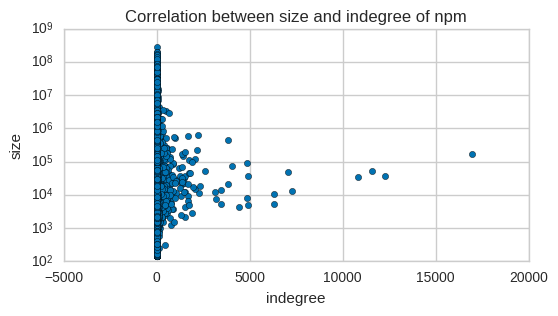

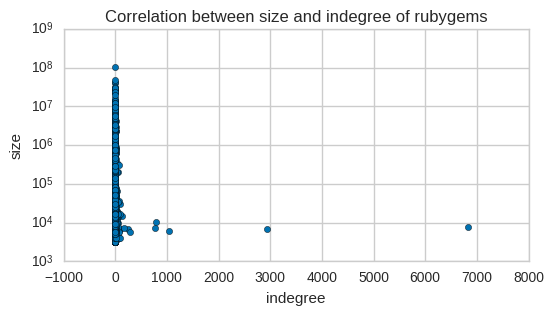

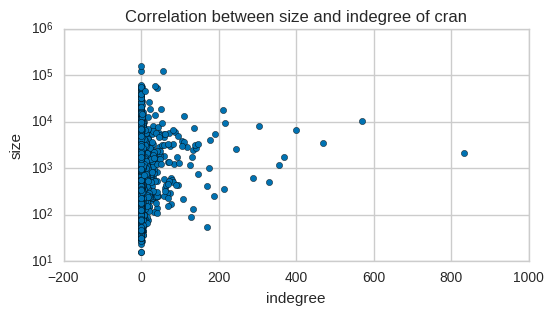

In [11]:
for e, data in package_metrics.items():
    fig, ax = matplotlib.pyplot.subplots()
    data[data.date == '2016-01-01'].plot.scatter(x='indegree', y='size', ax=ax)
    if SHOW_TITLE:
        ax.set_title('Correlation between size and indegree of {}'.format(e))
    ax.set_yscale('log')
    fig.set_size_inches(FIG_SIZE)
    savefig(fig, 'scatter_size_in_{}'.format(e))

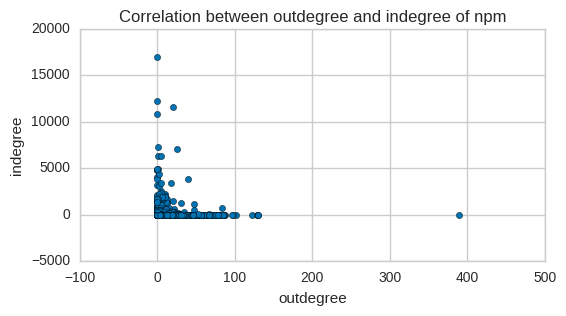

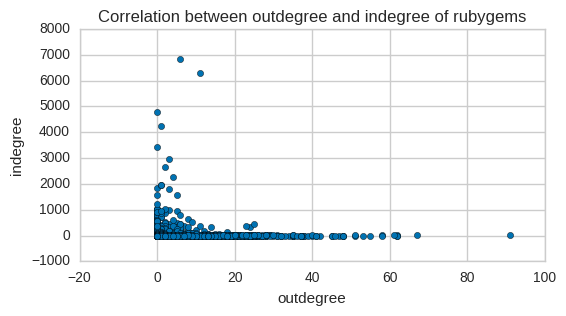

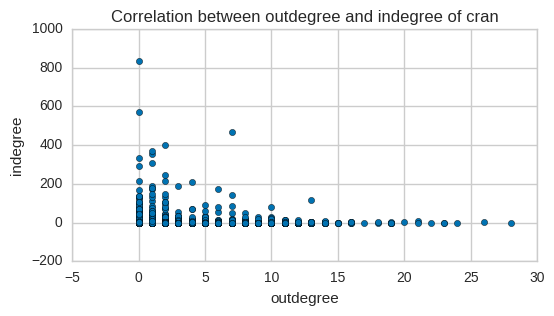

In [12]:
for e, data in package_metrics.items():
    fig, ax = matplotlib.pyplot.subplots()
    data[data.date == '2016-01-01'].plot.scatter(x='outdegree', y='indegree', ax=ax)
    if SHOW_TITLE:
        ax.set_title('Correlation between outdegree and indegree of {}'.format(e))
    fig.set_size_inches(FIG_SIZE)
    savefig(fig, 'scatter_in_out_{}'.format(e))

## Coverage

In [13]:
def coverage(g, limit, mode="out"):
    n = 0
    res = []
    while n < limit:
        size = g.neighborhood_size(order=len(g.vs), mode=mode)
        node = g.vs[size.index(max(size))]['name']
        res.append(node)
        neighborhood = [g.vs[x]['name'] for x in g.neighborhood(node, len(g.vs), mode)]
        n += len(neighborhood)
        g = g.induced_subgraph(set(g.vs['name']).difference(neighborhood))
    return res

def non_isolated(g):
    return g.induced_subgraph([v for d, v in zip(g.degree(), g.vs['name']) if d > 0])

In [14]:
def compute_coverage(e, g):
    g = graphs[e][max(graphs[e].keys())]
    g = non_isolated(g)
    print(e)
    print(pandas.datetime.now())
    res = [{'ecos': e, 'non_isolated': len(g.vs), 'ratio': ratio,
            'breakers': coverage(g, len(g.vs) * ratio, 'in')}
           for ratio in map(lambda i: (i + 1) / 10, range(10))]
    print(pandas.datetime.now())
    return res

coverage_result = pandas.concat([pandas.DataFrame(compute_coverage(e, g)) for e, g in graphs.items()])

npm
2016-09-16 10:11:15.219463
2016-09-16 10:14:59.383177
cran
2016-09-16 10:14:59.404915
2016-09-16 10:14:59.875019
rubygems
2016-09-16 10:14:59.956755
2016-09-16 10:15:13.919763


                                            breakers      ecos  non_isolated  \
0                                         [inherits]       npm        183748   
1                                         [inherits]       npm        183748   
2                                         [inherits]       npm        183748   
3                                         [inherits]       npm        183748   
4                                 [inherits, lodash]       npm        183748   
5           [inherits, lodash, underscore, minimist]       npm        183748   
6  [inherits, lodash, underscore, minimist, ms, g...       npm        183748   
7  [inherits, lodash, underscore, minimist, ms, g...       npm        183748   
8  [inherits, lodash, underscore, minimist, ms, g...       npm        183748   
9  [inherits, lodash, underscore, minimist, ms, g...       npm        183748   
0                                             [grid]      cran          7334   
1                                       

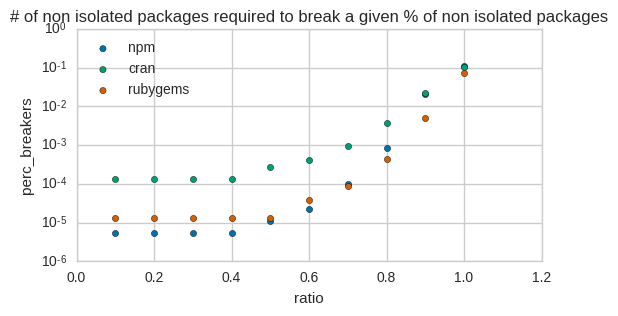

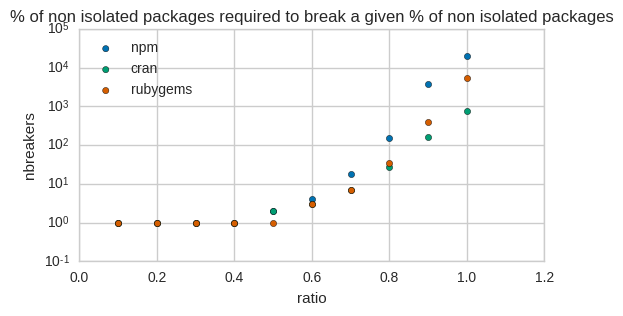

In [15]:
data = (coverage_result.assign(nbreakers=lambda d: list(map(len, d.breakers)))
                       .assign(perc_breakers=lambda d: d.nbreakers / d.non_isolated))
print(data)

fig, ax = matplotlib.pyplot.subplots()
for e in graphs.keys():
    kwargs = {
        'x': 'ratio', 
        'y': 'perc_breakers',
        'label': e,
        'logy': True,
        'color': COLORS[e],
        'ax': ax
    }
    if ax:
        kwargs['ax'] = ax
        
    data.query('ecos == "{}"'.format(e)).plot.scatter(**kwargs)
#ax.set_xlabel('size of the subgraph')
#ax.set_ylabel('number of subgraphs')
#ax.set_xlim(left=0)
#ax.set_ylim(bottom=0)
ax.legend(loc='upper left')

if SHOW_TITLE:
    ax.set_title('# of non isolated packages required to break a given % of non isolated packages')
fig.set_size_inches(FIG_SIZE)
savefig(fig, 'breakers_relative')

fig, ax = matplotlib.pyplot.subplots()
for e in graphs.keys():
    kwargs = {
        'x': 'ratio', 
        'y': 'nbreakers',
        'label': e,
        'logy': True,
        'color': COLORS[e],
        'ax': ax
    }
    if ax:
        kwargs['ax'] = ax
        
    ax = data.query('ecos == "{}"'.format(e)).plot.scatter(**kwargs)
#ax.set_xlabel('size of the subgraph')
#ax.set_ylabel('number of subgraphs')
#ax.set_xlim(left=0)
#ax.set_ylim(bottom=0)
ax.legend(loc='upper left')

if SHOW_TITLE:
    ax.set_title('% of non isolated packages required to break a given % of non isolated packages')
fig.set_size_inches(FIG_SIZE)
savefig(fig, 'breakers')